In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
import sklearn.model_selection as ms
import sklearn.metrics as sklm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as nr
import seaborn as sns
from datetime import date
from sklearn import linear_model
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from scipy.special import boxcox1p
from sklearn.neural_network import MLPRegressor
import scipy.stats as ss
from scipy.stats import skew
import math
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.to_csv('traincheck1.csv')
test.to_csv('testcheck1.csv')

#This being an incorporation of the deep feature investigation shown in the complete solution. 
#Following steps, taking some code, but ultimately trying to write my own.

In [4]:
#I REALLY, REALLY like the layout and output of this function that I pulled from Marquelo Marques's example.
#I'm going to end up using and re-using this one a lot, I think. Renamed function 'DataDetails'
#https://www.kaggle.com/mgmarques/houses-prices-complete-solution

def DataDetails(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew() #Pandas
    kurtosis = df.kurt()  #Pandas
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [5]:
details = DataDetails(train, 'SalePrice')
details.to_csv('DatasetDetails.csv')
display(details.sort_values(by='corr SalePrice', ascending=False))

Data shape: (1460, 81)
___________________________
Data types:
 object     43
int64      35
float64     3
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr SalePrice
SalePrice,int64,1460,663,0,0.000000,"[[208500, 181500, 223500, 140000, 250000, 1430...",1.882876,6.536282,1.000000
OverallQual,int64,1460,10,0,0.000000,"[[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]]",0.216944,0.096293,0.790982
GrLivArea,int64,1460,861,0,0.000000,"[[1710, 1262, 1786, 1717, 2198, 1362, 1694, 20...",1.366560,4.895121,0.708624
GarageCars,int64,1460,5,0,0.000000,"[[2, 3, 1, 0, 4]]",-0.342549,0.220998,0.640409
GarageArea,int64,1460,441,0,0.000000,"[[548, 460, 608, 642, 836, 480, 636, 484, 468,...",0.179981,0.917067,0.623431
TotalBsmtSF,int64,1460,721,0,0.000000,"[[856, 1262, 920, 756, 1145, 796, 1686, 1107, ...",1.524255,13.250483,0.613581
1stFlrSF,int64,1460,753,0,0.000000,"[[856, 1262, 920, 961, 1145, 796, 1694, 1107, ...",1.376757,5.745841,0.605852
FullBath,int64,1460,4,0,0.000000,"[[2, 1, 3, 0]]",0.036562,-0.857043,0.560664
TotRmsAbvGrd,int64,1460,12,0,0.000000,"[[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]]",0.676341,0.880762,0.533723
YearBuilt,int64,1460,112,0,0.000000,"[[2003, 1976, 2001, 1915, 2000, 1993, 2004, 19...",-0.613461,-0.439552,0.522897


NOTES:

Some Initial Steps to Take: Consider dropping 10 features.

A. These columns are all over 47% null.
PoolQC
MiscFeature  <--- I like the data in this column (e.g. has a shed, etc). but it's over 96% null!
Alley
Fence
FireplaceQu

B. These columns have low correlation.
TSsnPorch
BsmtFinSF2
BsmtHalfBath
MiscVal
LowQualFinSF

In [6]:
#DUMPING CORRELATIONS TO CSV
c = train.corr()
s = c.unstack()
so = s.sort_values(kind="quicksort")
so.to_csv("Correls.csv")

In [7]:
#Using a heatmap to check correlations
#plt.figure(figsize=[40,20])
#sns.heatmap(train.corr(), annot=True)

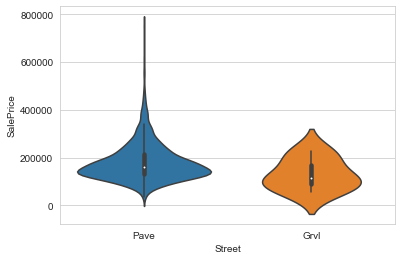

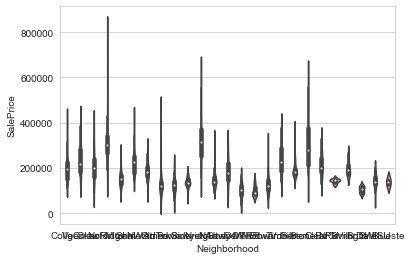

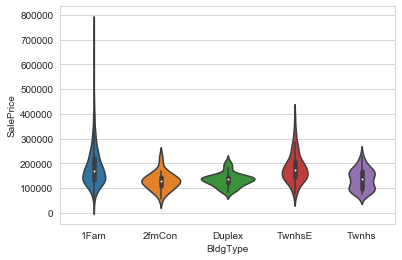

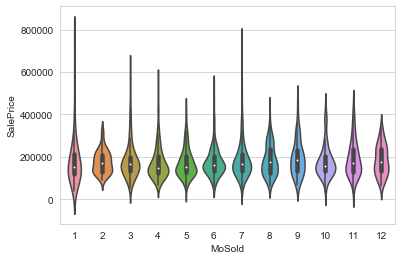

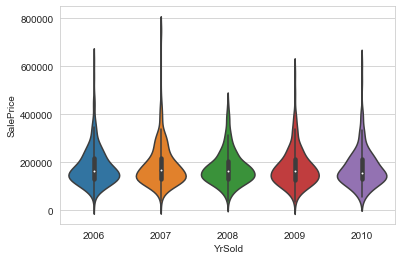

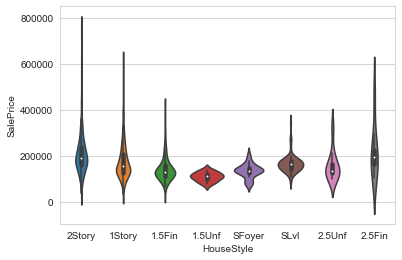

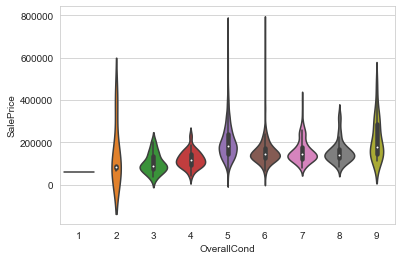

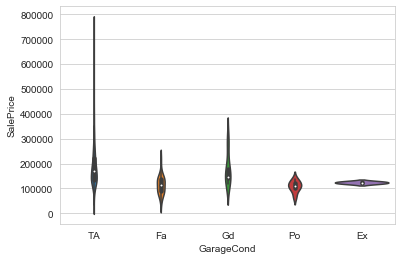

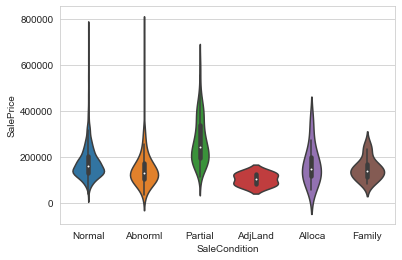

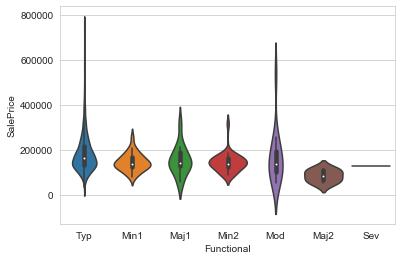

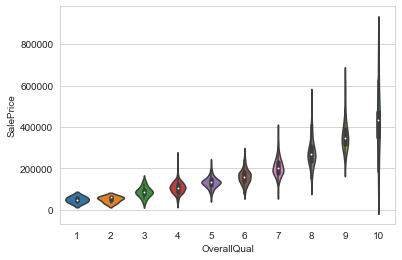

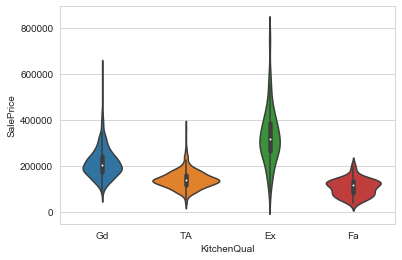

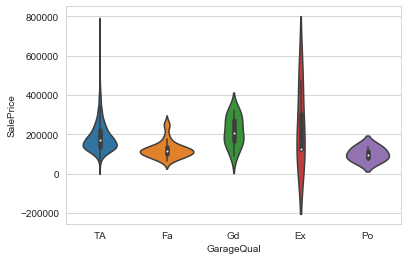

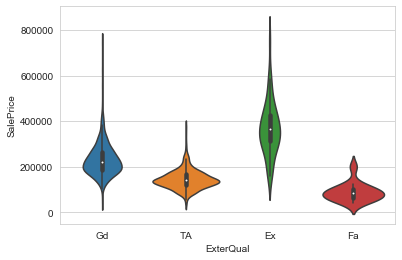

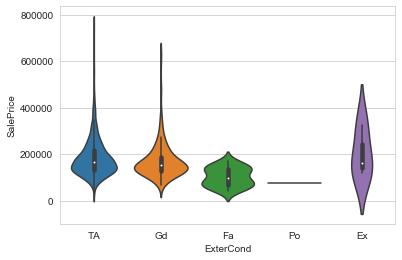

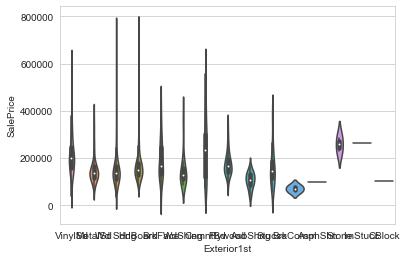

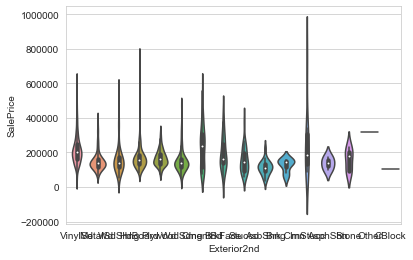

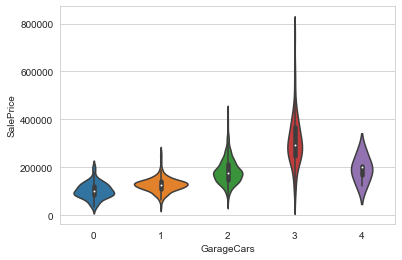

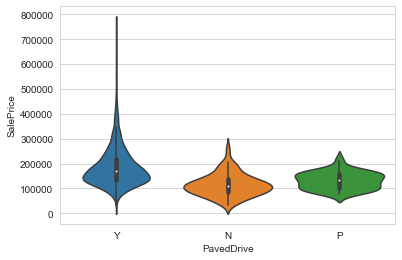

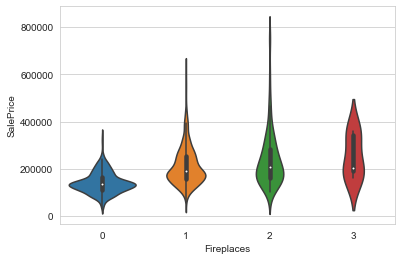

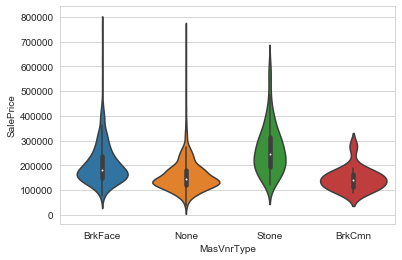

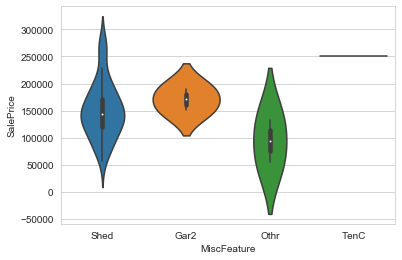

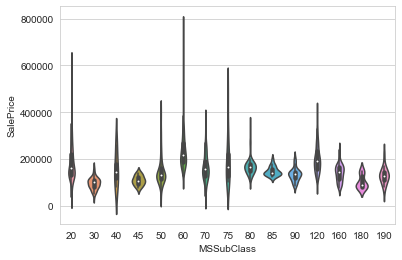

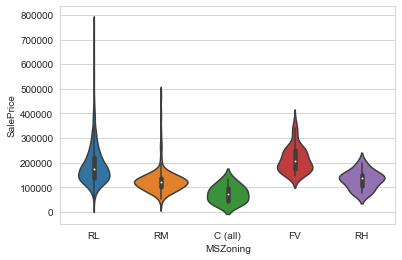

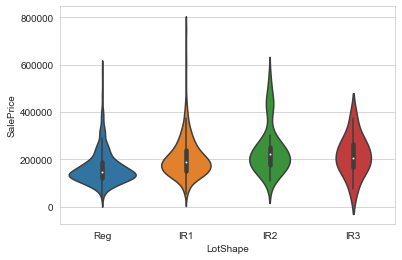

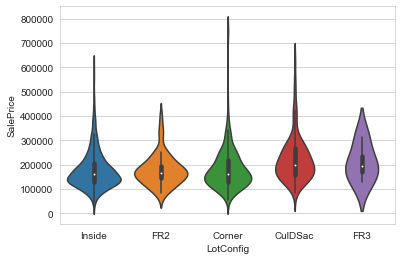

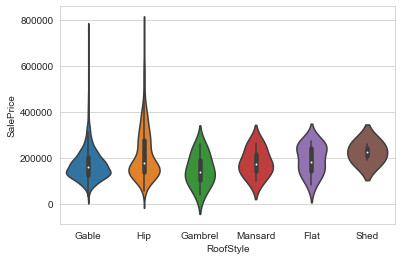

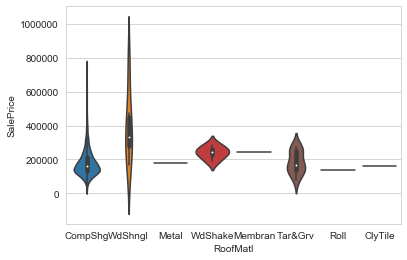

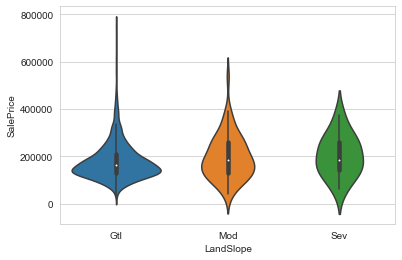

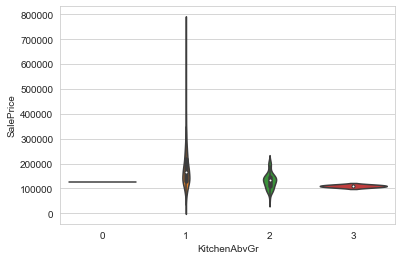

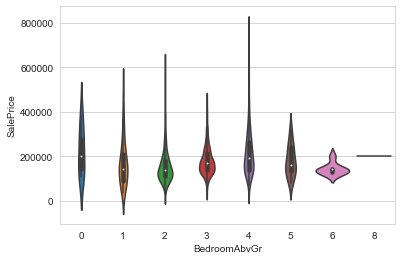

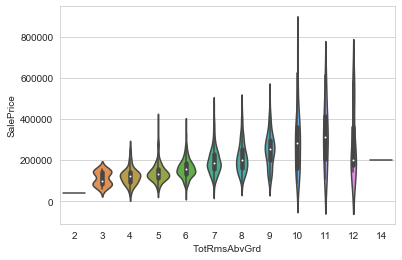

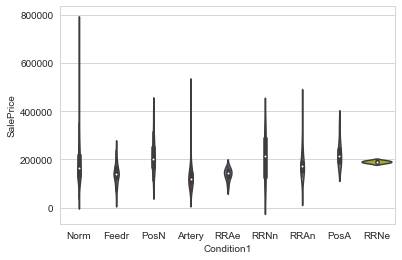

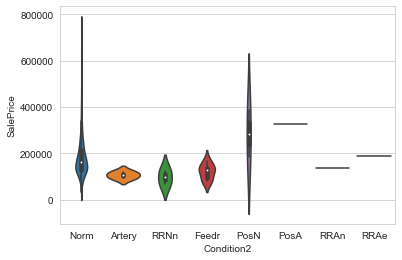

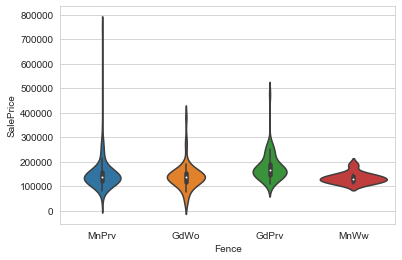

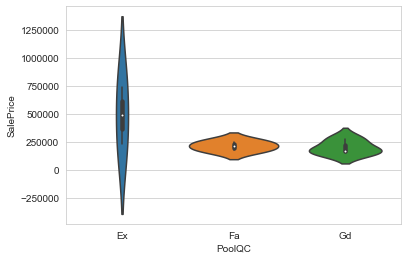

In [8]:
#Using Violin plots to check distributions, for categorical variables.
TrainCatCols = ['Street','Neighborhood','BldgType','MoSold','YrSold','HouseStyle',
            'OverallCond','GarageCond','SaleCondition','Functional',
            'OverallQual','KitchenQual','GarageQual','ExterQual',
            'ExterCond','Exterior1st','Exterior2nd','GarageCars',
            'PavedDrive','Fireplaces','MasVnrType','MiscFeature',
            'MSSubClass','MSZoning','LotShape','LotConfig','RoofStyle',
            'RoofMatl','LandSlope','KitchenAbvGr','BedroomAbvGr','TotRmsAbvGrd',
            'Condition1','Condition2','Fence','PoolQC']

def plot_violin(train, TrainCatCols, col_y ='SalePrice', kind ='kde'):
    for col in TrainCatCols:
        sns.set_style("whitegrid")
        sns.violinplot(col,col_y, data=train)
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel(col_y)# Set text for y axis
        plt.show()

plot_violin(train,TrainCatCols)


HANDLING NA / NAN / NULL VALUES

A. Categorical
B. Numeric
C. Mixed Categorical / Numeric

In [9]:
#CATEGORICAL
for col in ('Utilities','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinType2','GarageType','GarageFinish','GarageQual','GarageCond','Alley','Fence','MiscFeature'
          ):
    train[col]=train[col].fillna('None')
    test[col]=test[col].fillna('None')



In [10]:
#CATEGORICAL 2 -- PREDICTING THE MOST COMMON
train.Electrical = train.Electrical.fillna('SBrkr')
test.Electrical = test.Electrical.fillna('SBrkr')

NEXT: Some Basic Administration

A. Replace N/A with 'None'
B. Replace N/A with 0
C. Ordinal Transformation for Categories

In [11]:
#NUMERIC - REPLACE WITH THE MODE
for col in ('MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional'):
    train[col]=train[col].fillna(train[col].mode()[0])
    test[col]=test[col].fillna(test[col].mode()[0])

In [12]:
#NUMERIC - REPLACE WITH 0
for col in ('LotFrontage','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','GarageYrBlt','GarageCars','GarageArea','GarageYrBlt'):
    train[col]=train[col].fillna(0)
    test[col]=test[col].fillna(0)    

In [13]:
#Ordinal assignments seem most appropriate for 9 point scales
#Important since Overall Quality and Overall Condition are numeric scales -- this harmonizes.

for col in ('ExterQual','GarageQual','KitchenQual','BsmtQual','ExterCond','BsmtCond','GarageCond','HeatingQC','PoolQC'):    
    train[col]=train[col].fillna(0)
    test[col]=test[col].fillna(0)   
    train[col][train[col] == 'Ex'] = 9
    train[col][train[col] == 'Gd'] = 7
    train[col][train[col] == 'TA'] = 5
    train[col][train[col] == 'Fa'] = 3
    train[col][train[col] == 'Po'] = 1
    train[col][train[col] == 'NA'] = 0
    train[col][train[col] == 'None'] = 0
    train[col].astype('int32')
    test[col][test[col] == 'Ex'] = 9
    test[col][test[col] == 'Gd'] = 7
    test[col][test[col] == 'TA'] = 5
    test[col][test[col] == 'Fa'] = 3
    test[col][test[col] == 'Po'] = 1
    test[col][test[col] == 'NA'] = 0
    test[col][test[col] == 'None'] = 0
    test[col].astype('int32')

QUALITY COLUMNS - HIGH OVERLAP / IMPROVEMENTS?

Many of the Quality Metrics: Overall Quality, External Quality, Garage Quality, Kitchen Quality, and Basement Quality represent the same information.

It seems most appropriate to either work from a single atomic quality feature, OR to seek to make the location-specific quality measures as atomic as possible. 


In [14]:
train['QualIndex'] = np.power(train.OverallQual, 2)+train.ExterQual+train.GarageQual+train.KitchenQual+train.BsmtQual
test['QualIndex'] = np.power(test.OverallQual, 2)+test.ExterQual+test.GarageQual+test.KitchenQual+test.BsmtQual
#train['QualIndex1'] = train.ExterQual+train.GarageQual+train.KitchenQual+train.BsmtQual
#train['QualIndex3'] = train.QualIndex3/6
#train['QualIndex1']=train['QualIndex1'].astype('int32')
#train['QualIndex2']=train['QualIndex2'].astype('int32')
train['QualIndex']=train['QualIndex'].astype('int32')
test['QualIndex']=test['QualIndex'].astype('int32')

In [15]:
#df.QualIndex1.corr(df['SalePrice'])

Text(0.5, 1.0, 'Correlation with SalePrice: 0.8316')

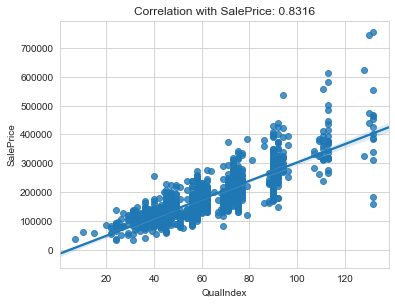

In [16]:
fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(231); sns.regplot(x='QualIndex', y='SalePrice', data=train)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train.QualIndex.corr(train['SalePrice'])))

QUALITY: CONCLUSIONS

Emphasizing Overall Quality's impact upon pricing has some intuitive sense.
> Good idea to test with and without / overfitting is a potential. 



CONDITION FEATURES
OverallCond
BsmtCond
GarageCond
ExterCond
HeatingQC #Heating quality and condition

I again want to test the value of an index.

In [17]:
#train['CondIndex'] = train.OverallCond+train.BsmtCond+train.GarageCond+train.ExterCond+train.HeatingQC 
#train['CondIndex2'] = train.BsmtCond+train.GarageCond+train.ExterCond+train.HeatingQC 
#train['CondIndex3'] = train.BsmtCond+train.GarageCond+train.ExterCond
#train['CondIndex']=train['CondIndex'].astype('int32')
#train['CondIndex2']=train['CondIndex2'].astype('int32')
#train['CondIndex3']=train['CondIndex3'].astype('int32')

In [18]:
#df.CondIndex.corr(df['SalePrice'])

In [19]:
#df.CondIndex2.corr(df['SalePrice'])

In [20]:
#df.CondIndex3.corr(df['SalePrice'])

In [21]:
train['ConditionIndex'] = train.BsmtCond+train.GarageCond+train.ExterCond+train.HeatingQC
test['ConditionIndex'] = test.BsmtCond+test.GarageCond+test.ExterCond+test.HeatingQC
test['ConditionIndex']=test['ConditionIndex'].astype('int32')
train['ConditionIndex']=train['ConditionIndex'].astype('int32')

'PoolQC' #Pool Quality  --> I'm thinking that there are two issues with pools:
1. Does it have a pool?, and
2. Is it a good quality pool?

Very few houses have pools, but perhaps having a pool is a lift to price. I will not drop PoolQC to start with.

In [22]:
train['HasAGoodPool'] = np.where(train['PoolQC']=='Ex',1,np.where(train['PoolQC']=='Gd',1,0))
test['HasAGoodPool'] = np.where(test['PoolQC']=='Ex',1,np.where(test['PoolQC']=='Gd',1,0))

In [23]:
test.to_csv('testcheck111.csv')
train.to_csv('traincheck111.csv')

HANDLING AGE OF HOUSE

A Numeric Years Old at Date of Sale should be far more easily consumed by algorithm than YrSold and YearBuilt

In [24]:
train['AgeAsOfSale'] = np.where(train.YrSold-train.YearBuilt<0,0,train.YrSold-train.YearBuilt)
train['AgeGarageAsOfSale'] = train.GarageYrBlt-train.YearBuilt
test['AgeAsOfSale'] = np.where(test.YrSold-test.YearBuilt<0,0,test.YrSold-test.YearBuilt)
test['AgeGarageAsOfSale'] = np.where(test.GarageYrBlt-test.YearBuilt<0,0,test.GarageYrBlt-test.YearBuilt)
train['YearsSinceRemod'] = np.where(train.YrSold-train.YearRemodAdd<0,0,train.YrSold-train.YearRemodAdd)
test['YearsSinceRemod'] = np.where(test.YrSold-test.YearRemodAdd<0,0,test.YrSold-test.YearRemodAdd)

YEAR SOLD --

The Great Recession HIT in 2008 ---> And this dataset spans 2006 - 2010. 

Year Sold ABSOLUTELY Has an Impact on Sale Price.
--- NOT on THE MIN Price. NOT on the AVG Price. BUT YES on the MAX Price

Year	 Avg SalePrice 	 Min SalePrice 	 Max SalePrice 
2006	 182,549 	 35,311 	 625,000 
2007	 186,063 	 39,300 	 755,000 
2008	 177,361 	 40,000 	 446,261  <--- Max Price is Sharply Down
2009	 179,432 	 34,900 	 582,933 
2010	 177,394 	 55,000 	 611,657 

How Do I Model This Properly? --> Encourage the algorithm to drop high end prices in 2008?

This is NOT a Linear process.


In [25]:
#YrSold

train['SoldIn2008'] = np.where(train.YrSold==2018,1,0)
test['SoldIn2008'] = np.where(test.YrSold==2018,1,0)

In [26]:
train.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)
test.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)

HANDLING NEIGHBORHOOD

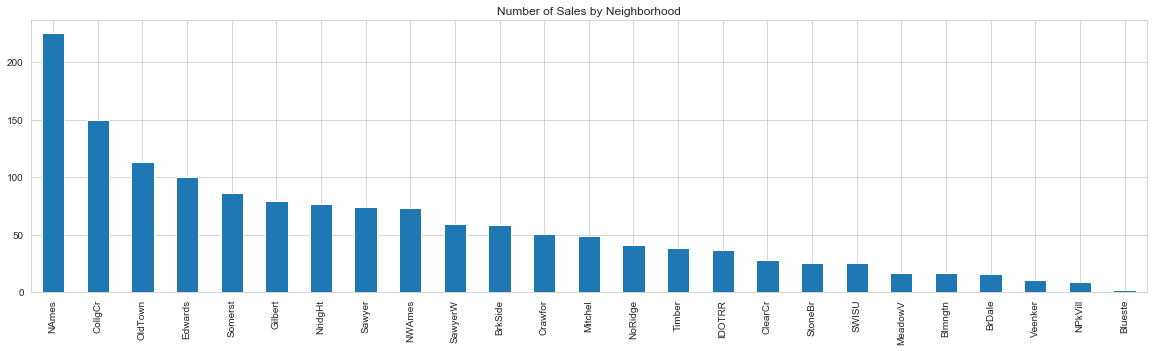

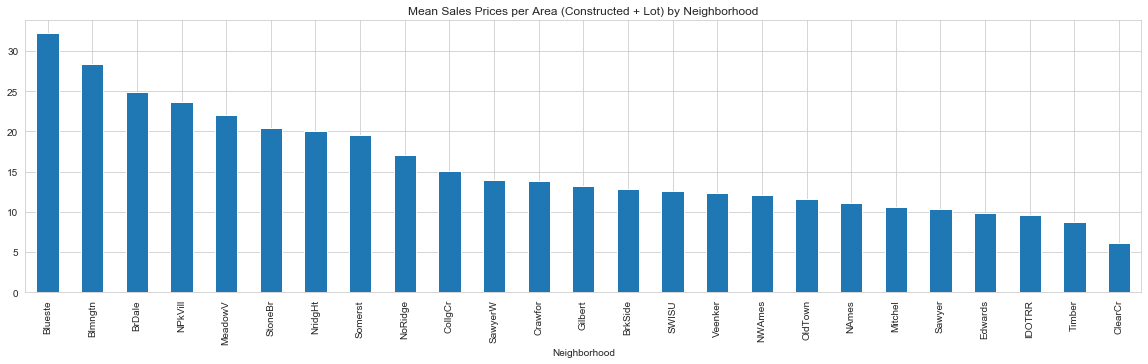

In [27]:
#Stealing code. 
figa = plt.figure(figsize=(20, 5))
g = train.Neighborhood.value_counts().plot(kind='bar', title='Number of Sales by Neighborhood')

figb = plt.figure(figsize=(20, 5))
plt.tight_layout()
df = train[['SalePrice', 'YrSold', 'Neighborhood']]

df['TotalArea'] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                   train.LotArea.fillna(0) + train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + 
                   train.OpenPorchSF.fillna(0) + train.TSsnPorch.fillna(0) + train.ScreenPorch.fillna(0) + 
                   train.EnclosedPorch.fillna(0) + train.PoolArea.fillna(0) )
 
df = df.groupby(by=['Neighborhood', 'YrSold'], as_index=False).sum()
Neig = df[['SalePrice', 'TotalArea', 'Neighborhood']].groupby(by='Neighborhood', as_index=False).sum()
Neig['NeigPrice'] = Neig.SalePrice / Neig.TotalArea
Neig.drop(['TotalArea', 'SalePrice'], axis=1, inplace=True)
g = Neig.groupby('Neighborhood').NeigPrice.sum().sort_values(ascending = False).\
    plot(kind='bar', title='Mean Sales Prices per Area (Constructed + Lot) by Neighborhood')
Neig = Neig.groupby(by='Neighborhood', as_index=True).NeigPrice.sum().sort_values(ascending = False)

In [28]:
#NeighboordQual = np.where train['NoRidge']
#train['NridgHt']
#train['StoneBr']

In [29]:
train.to_csv('traincheck21.csv')
test.to_csv('testcheck21.csv')

HANDLING SQUARE FOOTAGE OF HOUSE

BsmtFinSF1
1stFlrSF
2ndFlrSF
BsmtUnfSF
GarageArea
GrLivArea
LotArea
LotFrontage
MasVnrArea
OpenPorchSF
TotalBsmtSF
WoodDeckSF


In [30]:
train.BsmtUnfSF.corr(train['SalePrice'])

0.21447910554696892

In [31]:
train.BsmtFinSF1.corr(train['SalePrice'])

0.38641980624215316

In [32]:
train.BsmtFinSF2.corr(train['SalePrice'])

-0.011378121450215136

In [33]:
train.TotalBsmtSF.corr(train['SalePrice'])

0.6135805515591954

In [34]:
train.MasVnrArea.corr(train['SalePrice'])

0.4726144990045743

In [35]:
train['GoodWoodDeck'] = np.where(train['WoodDeckSF']>=200,1,0)
test['GoodWoodDeck'] = np.where(test['WoodDeckSF']>=200,1,0)

In [36]:
train.GoodWoodDeck.corr(train['SalePrice'])

0.2332932735163196

In [37]:
train['GoodOpenPorch'] = np.where(train['OpenPorchSF']>=50,1,0)
test['GoodOpenPorch'] = np.where(test['OpenPorchSF']>=50,1,0)

In [38]:
train.GoodOpenPorch.corr(train['SalePrice'])

0.3746428025350189

In [39]:
train['GoodScreenPorch'] =  np.where(train['ScreenPorch']>=50,1,0)
test['GoodScreenPorch'] =  np.where(test['ScreenPorch']>=50,1,0)

In [40]:
train.GoodScreenPorch.corr(train['SalePrice'])

0.0894070461704025

In [41]:
train['LotAreaGood'] = np.where(train['LotArea']>50000,4,np.where(train['LotArea']>20000,3,np.where(train['LotArea']>10000,2,1)))
test['LotAreaGood'] = np.where(test['LotArea']>50000,4,np.where(test['LotArea']>20000,3,np.where(test['LotArea']>10000,2,1)))

In [42]:
train.LotAreaGood.corr(train['SalePrice'])

0.40109041401959666

LotArea
LotFrontage

GrLivArea

BsmtUnfSF  -- There
BsmtFinSF1 -- There
BsmtFinSF2 -- There
TotalBsmtSF -- There

LowQualFinSF

ScreenPorch
OpenPorchSF

MasVnrArea  -- There
GarageArea

1stFlrSF
2ndFlrSF

WoodDeckSF  -- There

GarageArea
GrLivArea
LotArea
LotFrontage
OpenPorchSF
TotalBsmtSF
WoodDeckSF

REMINDER - My Created Columns
ConditionIndex'

PREPARING FOR TRANSFORMS AND Option 1: Reduce Train and Test to Columns that 

In [43]:
#Deleting outliers -- from training only
train = train.drop(train[(train.OverallQual>8) & (train.SalePrice<300000)].index) #High Quality and Low Price

In [44]:
train.to_csv('traincheck3.csv')
test.to_csv('testcheck3.csv')

In [45]:
TrainTest = train.append(test) 

In [46]:
#Addition - Removing columns that I created columns for for.How much impact would this be?

#Dumping these columns cost me a full percent difference (.136 with this vs .125 without)
#It's most vexing -- but I'd prefer to work with features that I choose myself. 

#Is it possible that the quality metric is of such importance as a predictor that it's getting drowned out by all of these columns?
TrainTest.drop(['OverallCond','BsmtCond','GarageCond','ExterCond','HeatingQC'], axis=1, inplace=True) #Condition
TrainTest.drop(['GarageYrBlt', 'YrSold','YearBuilt','YearRemodAdd'], axis=1, inplace=True) #Year. Replaced with Age
TrainTest.drop(['OverallQual','ExterQual','GarageQual','KitchenQual','BsmtQual'], axis=1, inplace=True) #Quality
TrainTest.drop(['TSsnPorch','BsmtFinSF2','BsmtHalfBath','MiscVal','LowQualFinSF','PoolArea'], axis=1, inplace=True) #Low Correlation, Low Impact
TrainTest.drop(['MoSold'], axis=1, inplace=True)
TrainTest.drop(['LotArea','LotFrontage','GrLivArea','BsmtUnfSF','BsmtFinSF1','TotalBsmtSF','ScreenPorch','OpenPorchSF','MasVnrArea','GarageArea','1stFlrSF','2ndFlrSF','WoodDeckSF'], axis=1, inplace=True)
TrainTest.drop(['Id'], axis=1, inplace=True) #We don't want to run predictions based on the ID column.
TrainTest.drop(['SaleType'], axis=1, inplace=True) #I'm not confident in the SaleType column.
TrainTest.drop(['RoofMatl'], axis=1, inplace=True) #Roof Material: so dominated by compound shingles, there's no directional help.
TrainTest.drop(['PoolQC'], axis=1, inplace=True)  #Pool Quality. Few measurements. HasGoodPool bool is my pool measurement.
TrainTest.drop(['Condition2','Electrical'], axis=1, inplace=True)  #Condition


In [47]:
TrainTest.to_csv('TrainTestCheck3.csv')

In [48]:
TrainTest = pd.get_dummies(TrainTest,dummy_na=False)

In [49]:
TrainTest.to_csv('TrainTestCheck4.csv')

In [50]:
#Appending PCA Scores --> array must not contain infs or NaNs. Where do they come from?
#I think I want to delete any column that is 100% 0.
#These appear to be unwelcome remnants of get_dummies -- dummy_na = True. Perhaps set to false, I'll find this step unnecessary. 
#(TrainTest != 0).any(axis=0) ==True
TrainTest = TrainTest.loc[:, (TrainTest != 0).any(axis=0)]

In [51]:
#Got array must not contain infs or NaNs and then LinAlgError: SVD did not converge errors. 
#Here's a script to get rid of infs and nans.
TrainTest.SalePrice = TrainTest.SalePrice.fillna(0)

In [52]:
TrainTest.isnull().values.any()  #No null values

False

In [53]:
train = TrainTest.loc[(TrainTest.SalePrice>0)].reset_index(drop=True, inplace=False)
test = TrainTest.loc[(TrainTest.SalePrice==0)].reset_index(drop=True, inplace=False)

In [54]:
y=train['SalePrice']

In [55]:
#train.drop(['SalePrice'],axis=1,inplace=True)
train.to_csv('TrainFinalCheck.csv')
test.to_csv('TestFinalCheck.csv')

In [56]:
#A hack for dtypes.
train['BsmtFullBath']=train['BsmtFullBath'].astype('int32')
train['GarageCars']=train['GarageCars'].astype('int32')
train['GoodOpenPorch']=train['GoodOpenPorch'].astype('bool')
train['GoodScreenPorch']=train['GoodScreenPorch'].astype('bool')
train['GoodWoodDeck']=train['GoodWoodDeck'].astype('bool')
train['LotAreaGood']=train['LotAreaGood'].astype('int32')

In [57]:
test['BsmtFullBath']=test['BsmtFullBath'].astype('int32')
test['GarageCars']=test['GarageCars'].astype('int32')
test['GoodOpenPorch']=test['GoodOpenPorch'].astype('bool')
test['GoodScreenPorch']=test['GoodScreenPorch'].astype('bool')
test['GoodWoodDeck']=test['GoodWoodDeck'].astype('bool')
test['LotAreaGood']=test['LotAreaGood'].astype('int32')

In [58]:
details = DataDetails(train, 'SalePrice')
details.to_csv('DatasetDetails2.csv')
display(details.sort_values(by='corr SalePrice', ascending=False))

Data shape: (1453, 212)
___________________________
Data types:
 uint8      192
int64       10
int32        5
bool         3
float64      2
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr SalePrice
SalePrice,float64,1453,660,0,0.0,"[[208500.0, 181500.0, 223500.0, 140000.0, 2500...",1.896119,6.591522,1.000000
QualIndex,int32,1453,60,0,0.0,"[[75, 58, 71, 90, 47, 92, 67, 45, 113, 56, 69,...",0.760585,0.607190,0.839922
GarageCars,int32,1453,5,0,0.0,"[[2, 3, 1, 0, 4]]",-0.340079,0.216995,0.640686
FullBath,int64,1453,4,0,0.0,"[[2, 1, 3, 0]]",0.037796,-0.869030,0.560990
TotRmsAbvGrd,int64,1453,12,0,0.0,"[[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]]",0.659017,0.846252,0.539267
Foundation_PConc,uint8,1453,2,0,0.0,"[[1, 0]]",0.240082,-1.945040,0.496285
Fireplaces,int64,1453,4,0,0.0,"[[0, 1, 2, 3]]",0.635544,-0.289660,0.469754
ConditionIndex,int32,1453,19,0,0.0,"[[24, 22, 20, 15, 26, 18, 16, 10, 17, 28, 11, ...",-1.233682,2.383612,0.457470
BsmtFinType1_GLQ,uint8,1453,2,0,0.0,"[[1, 0]]",0.957689,-1.084326,0.434578
GarageFinish_Fin,uint8,1453,2,0,0.0,"[[0, 1]]",1.230896,-0.485564,0.418734


In [59]:
train = train.drop('SalePrice',axis=1)
test = test.drop('SalePrice',axis=1)

In [60]:
#Factor Analysis and PCA require scaling.
sc=RobustScaler()
train=pd.DataFrame(sc.fit_transform(train.values))
test=pd.DataFrame(sc.fit_transform(test.values))

fig, ax = plt.subplots(figsize=(8, 4))
lines = ax.plot(pd.DataFrame(pca_model.factors).iloc[:,:10], lw=4, alpha=.6)
ax.set_xticklabels(TrainTest.columns.values[::10])
ax.set_xlim(0, 51)
fig.subplots_adjust(.1, .1, .85, .9)
legend = fig.legend(lines, ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6'], loc='center right')
legend.draw_frame(False)

In [61]:
train.to_csv('TrainFinalCheck2.csv')
test.to_csv('TestFinalCheck2.csv')

#Gridsearch seems to be flat out failing.
nr.seed(532)
nfolds = 10

#n_estimators=100,random_state=2
RFR = RandomForestRegressor(n_estimators=200) 

param_grid = {"max_features": [5, 9, 14, 20, 25, 30, 35], "min_samples_leaf":[3, 5, 10, 20]}
grid_search = GridSearchCV(RFR,  param_grid = param_grid, cv=nfolds)
grid_search.fit(train, y)

In [62]:
#y=np.log(y)

In [65]:
PoiReg = sm.GLM(y,train,data=train, family=sm.families.Poisson()).fit()

In [ ]:
Result = pd.DataFrame(PoiReg.predict(test))
Result = np.exp(Result)
Result.to_csv('resultreg22.csv')